# 🏠 Real Estate Price Prediction - Model Training & Evaluation

## Overview
This notebook focuses on machine learning model development for Tunisian real estate price prediction. We'll use the preprocessed and feature-engineered dataset to train, evaluate, and select the best performing model.

## Objectives
1. **Load preprocessed data** from feature engineering pipeline
2. **Feature selection** - identify most predictive features
3. **Data preparation** - train/validation/test splits and scaling
4. **Model training** - test multiple algorithms with hyperparameter tuning
5. **Model evaluation** - comprehensive performance analysis
6. **Model selection** - choose best performing model
7. **Model export** - save final model for deployment

## Models to Test
- **Linear Regression** (baseline)
- **Random Forest** (ensemble method)
- **XGBoost** (gradient boosting)
- **LightGBM** (fast gradient boosting)
- **Neural Networks** (deep learning)
- **Support Vector Regression** (kernel methods)

---

## 📚 Section 1: Import Libraries and Setup

In [42]:
# Core data manipulation and analysis
import pandas as pd
import numpy as np
import json
import os
import pickle
import joblib
import warnings
import time
from datetime import datetime
warnings.filterwarnings('ignore')

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Machine Learning - Preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_regression, RFE, SelectFromModel
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Machine Learning - Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

# Advanced ML libraries
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBOOST_AVAILABLE = False
    print("⚠️  XGBoost not available. Install with: pip install xgboost")

try:
    import lightgbm as lgb
    LIGHTGBM_AVAILABLE = True
except ImportError:
    LIGHTGBM_AVAILABLE = False
    print("⚠️  LightGBM not available. Install with: pip install lightgbm")

try:
    from sklearn.neural_network import MLPRegressor
    NEURAL_NETWORKS_AVAILABLE = True
except ImportError:
    NEURAL_NETWORKS_AVAILABLE = False

# Model evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import validation_curve, learning_curve

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Custom color palette
COLORS = {
    'primary': '#2E86AB',
    'secondary': '#A23B72', 
    'accent': '#F18F01',
    'success': '#5CB85C',
    'warning': '#F0AD4E',
    'danger': '#D9534F'
}

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("📚 Libraries imported successfully!")
print(f"🐼 Pandas version: {pd.__version__}")
print(f"🔢 NumPy version: {np.__version__}")
print(f"⚡ XGBoost available: {XGBOOST_AVAILABLE}")
print(f"💡 LightGBM available: {LIGHTGBM_AVAILABLE}")
print(f"🧠 Neural Networks available: {NEURAL_NETWORKS_AVAILABLE}")

📚 Libraries imported successfully!
🐼 Pandas version: 2.2.0
🔢 NumPy version: 1.26.4
⚡ XGBoost available: True
💡 LightGBM available: True
🧠 Neural Networks available: True


## 📊 Section 2: Load and Explore Preprocessed Data

Load the feature-engineered dataset from our preprocessing pipeline and understand its structure.

📊 Loading model-ready dataset from: ../data/processed/model_ready_dataset.json
✅ Dataset loaded: 1231 rows × 62 columns
✅ Metadata loaded with 8 feature descriptions
✅ Feature list loaded with 61 total features

📊 DATASET OVERVIEW
Shape: (1231, 62)
Memory usage: 0.52 MB
Missing values: 0

💰 TARGET VARIABLE (PRICE)
Valid prices: 1231
Missing prices: 0
Price range: 48,000 - 12,000,000 TND
Mean price: 665,861 TND
Median price: 450,000 TND


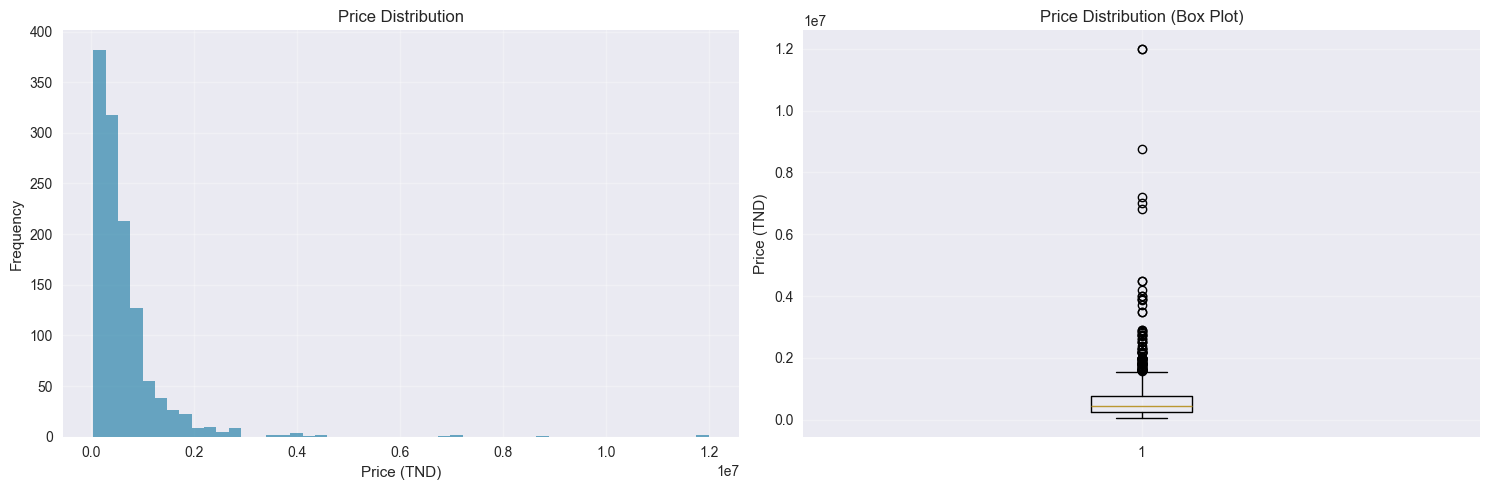

In [43]:
# Load the preprocessed dataset
def load_model_data():
    """
    Load the model-ready dataset and metadata from preprocessing pipeline.
    """
    # Paths to preprocessed data
    model_data_path = "../data/processed/model_ready_dataset.json"
    metadata_path = "../data/processed/feature_metadata.json"
    feature_list_path = "../data/processed/feature_list.json"
    
    # Load model dataset
    if os.path.exists(model_data_path):
        print(f"📊 Loading model-ready dataset from: {model_data_path}")
        df = pd.read_json(model_data_path, orient='records')
        print(f"✅ Dataset loaded: {df.shape[0]} rows × {df.shape[1]} columns")
    else:
        print(f"❌ Model dataset not found at: {model_data_path}")
        print("💡 Run the preprocessing notebook first!")
        return None, None, None
    
    # Load metadata
    metadata = None
    if os.path.exists(metadata_path):
        with open(metadata_path, 'r', encoding='utf-8') as f:
            metadata = json.load(f)
        print(f"✅ Metadata loaded with {len(metadata.get('feature_descriptions', {}))} feature descriptions")
    else:
        print(f"⚠️  Metadata not found at: {metadata_path}")
    
    # Load feature list
    feature_info = None
    if os.path.exists(feature_list_path):
        with open(feature_list_path, 'r', encoding='utf-8') as f:
            feature_info = json.load(f)
        print(f"✅ Feature list loaded with {len(feature_info.get('all_features', []))} total features")
    else:
        print(f"⚠️  Feature list not found at: {feature_list_path}")
    
    return df, metadata, feature_info

# Load the data
df_model, metadata, feature_info = load_model_data()

if df_model is not None:
    print(f"\n📊 DATASET OVERVIEW")
    print("=" * 50)
    print(f"Shape: {df_model.shape}")
    print(f"Memory usage: {df_model.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    print(f"Missing values: {df_model.isnull().sum().sum()}")
    
    # Check target variable
    if 'price' in df_model.columns:
        print(f"\n💰 TARGET VARIABLE (PRICE)")
        print("=" * 30)
        print(f"Valid prices: {df_model['price'].count()}")
        print(f"Missing prices: {df_model['price'].isnull().sum()}")
        print(f"Price range: {df_model['price'].min():,.0f} - {df_model['price'].max():,.0f} TND")
        print(f"Mean price: {df_model['price'].mean():,.0f} TND")
        print(f"Median price: {df_model['price'].median():,.0f} TND")
        
        # Price distribution visualization
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Histogram
        ax1.hist(df_model['price'], bins=50, alpha=0.7, color=COLORS['primary'])
        ax1.set_xlabel('Price (TND)')
        ax1.set_ylabel('Frequency')
        ax1.set_title('Price Distribution')
        ax1.grid(True, alpha=0.3)
        
        # Box plot
        ax2.boxplot(df_model['price'])
        ax2.set_ylabel('Price (TND)')
        ax2.set_title('Price Distribution (Box Plot)')
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    else:
        print("❌ Target variable 'price' not found!")
else:
    print("❌ Cannot proceed without dataset. Please run preprocessing notebook first.")

## 🎯 Section 3: Feature Selection and Engineering

Select the most predictive features for our machine learning models.

In [44]:
# Feature selection and preparation for modeling
def prepare_features_for_modeling(df, target_col='price'):
    """
    Prepare features for machine learning modeling.
    """
    if df is None:
        print("❌ No dataset provided")
        return None, None, None
    
    print("🎯 Preparing features for modeling...")
    
    # Remove target variable and non-predictive columns
    exclude_columns = [target_col, 'description', 'address', 'data_source']
    if 'description_clean' in df.columns:
        exclude_columns.append('description_clean')
    
    # Get feature columns
    feature_columns = [col for col in df.columns if col not in exclude_columns]
    
    # Separate features by type
    numerical_features = []
    binary_features = []
    categorical_features = []
    
    for col in feature_columns:
        if df[col].dtype in ['int64', 'float64']:
            unique_values = df[col].nunique()
            if unique_values <= 2:
                binary_features.append(col)
            elif unique_values > 10:
                numerical_features.append(col)
            else:
                categorical_features.append(col)
        else:
            categorical_features.append(col)
    
    print(f"📊 Feature Analysis:")
    print(f"   Total features: {len(feature_columns)}")
    print(f"   Numerical features: {len(numerical_features)}")
    print(f"   Binary features: {len(binary_features)}")
    print(f"   Categorical features: {len(categorical_features)}")
    
    # Check for missing values
    missing_stats = df[feature_columns].isnull().sum()
    features_with_missing = missing_stats[missing_stats > 0]
    
    if len(features_with_missing) > 0:
        print(f"\n⚠️  Features with missing values:")
        for feature, missing_count in features_with_missing.items():
            missing_pct = (missing_count / len(df)) * 100
            print(f"   {feature}: {missing_count} ({missing_pct:.1f}%)")
    else:
        print(f"✅ No missing values in features")
    
    return feature_columns, numerical_features, binary_features, categorical_features

# Analyze and prepare features
if df_model is not None:
    feature_cols, num_features, bin_features, cat_features = prepare_features_for_modeling(df_model)
    
    # Show sample of each feature type
    print(f"\n📋 Sample Features by Type:")
    if num_features:
        print(f"   Numerical: {num_features[:5]}...")
    if bin_features:
        print(f"   Binary: {bin_features[:5]}...")
    if cat_features:
        print(f"   Categorical: {cat_features[:3]}...")
else:
    print("❌ Cannot analyze features without dataset")

🎯 Preparing features for modeling...
📊 Feature Analysis:
   Total features: 61
   Numerical features: 14
   Binary features: 36
   Categorical features: 11
✅ No missing values in features

📋 Sample Features by Type:
   Numerical: ['living_area', 'land_area', 'room_count', 'price_per_sqm', 'total_area']...
   Binary: ['has_garage', 'has_garden', 'has_pool', 'has_balcony', 'has_terrace']...
   Categorical: ['bathroom_count', 'luxury_score', 'property_tier_Basic']...


📊 Analyzing feature importance...
🎯 Top 15 features by correlation with price:
    1. price_per_sqm            : 0.428
    2. bathroom_count           : 0.265
    3. is_appartement           : 0.239
    4. has_garden               : 0.234
    5. gov_ben_arous            : 0.231
    6. description_word_count   : 0.229
    7. description_length       : 0.220
    8. is_villa                 : 0.205
    9. land_area                : 0.195
   10. has_pool                 : 0.190
   11. has_swimming_pool        : 0.181
   12. luxury_score             : 0.166
   13. is_maison                : 0.164
   14. has_luxury               : 0.158
   15. ai_property_score        : 0.138


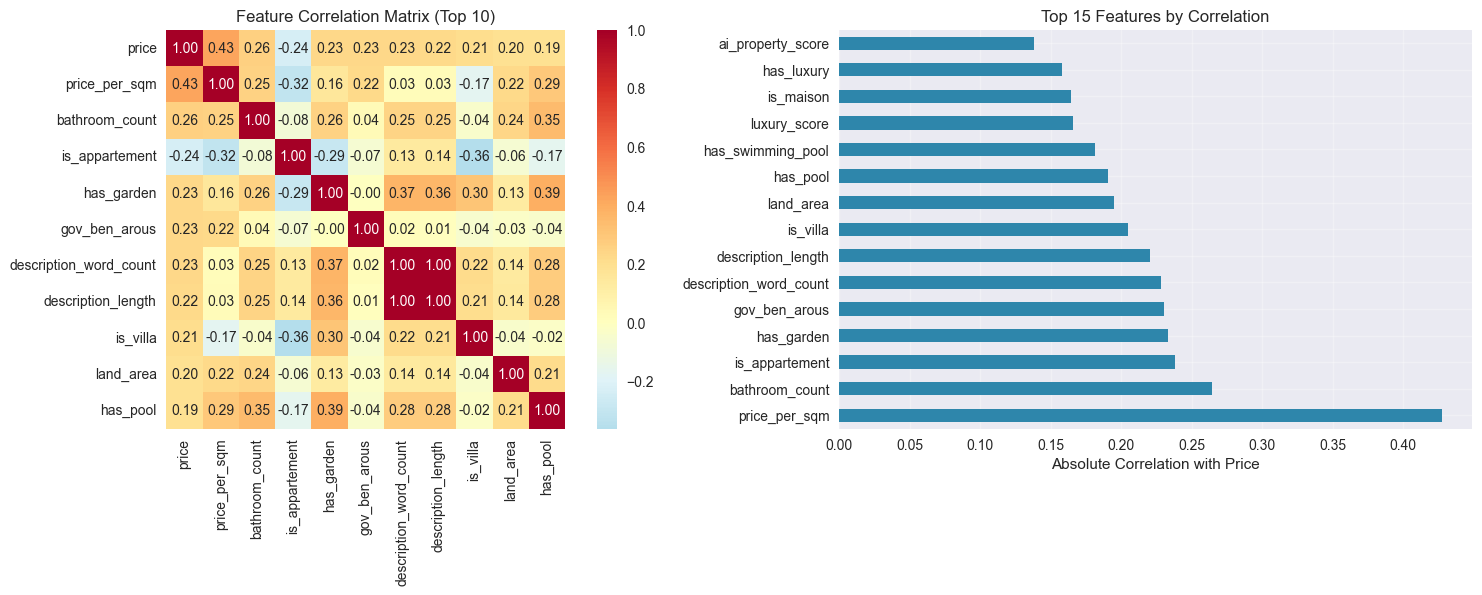


📈 Statistical Feature Selection:
   Top 10 features by F-statistic:
    1. land_area                : 48.60
    2. bathroom_count           : 92.51
    3. price_per_sqm            : 274.99
    4. description_length       : 62.73
    5. description_word_count   : 67.72
    6. has_garden               : 70.88
    7. has_pool                 : 46.24
    8. is_appartement           : 74.15
    9. is_villa                 : 53.96
   10. gov_ben_arous            : 69.12


In [45]:
# Correlation analysis and feature importance
def analyze_feature_importance(df, target_col='price', top_n=15):
    """
    Analyze feature importance using correlation and statistical methods.
    """
    if df is None:
        return None, None
    
    print("📊 Analyzing feature importance...")
    
    # Get numerical features for correlation analysis
    numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    
    # Calculate correlations with target
    correlations = df[numerical_cols].corr()[target_col].abs().sort_values(ascending=False)
    
    # Remove target variable from correlations
    correlations = correlations.drop(target_col)
    
    # Get top correlated features
    top_correlations = correlations.head(top_n)
    
    print(f"🎯 Top {top_n} features by correlation with price:")
    for i, (feature, corr) in enumerate(top_correlations.items(), 1):
        print(f"   {i:2d}. {feature:25s}: {corr:.3f}")
    
    # Visualize correlations
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Correlation heatmap for top features
    top_features_with_target = [target_col] + top_correlations.head(10).index.tolist()
    correlation_matrix = df[top_features_with_target].corr()
    
    sns.heatmap(correlation_matrix, annot=True, cmap='RdYlBu_r', center=0, 
                ax=ax1, fmt='.2f', square=True)
    ax1.set_title('Feature Correlation Matrix (Top 10)')
    
    # Bar plot of top correlations
    top_correlations.head(15).plot(kind='barh', ax=ax2, color=COLORS['primary'])
    ax2.set_xlabel('Absolute Correlation with Price')
    ax2.set_title('Top 15 Features by Correlation')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return top_correlations, correlation_matrix

# Run correlation analysis
if df_model is not None and 'price' in df_model.columns:
    top_corr, corr_matrix = analyze_feature_importance(df_model)
    
    # Statistical feature selection
    print(f"\n📈 Statistical Feature Selection:")
    
    # Prepare features and target
    X = df_model[feature_cols].select_dtypes(include=[np.number])
    y = df_model['price']
    
    # Remove any remaining missing values for this analysis
    mask = ~(X.isnull().any(axis=1) | y.isnull())
    X_clean = X[mask]
    y_clean = y[mask]
    
    if len(X_clean) > 0:
        # F-statistic feature selection
        f_selector = SelectKBest(score_func=f_regression, k=10)
        X_selected = f_selector.fit_transform(X_clean, y_clean)
        
        # Get selected feature names and scores
        selected_features = X_clean.columns[f_selector.get_support()]
        feature_scores = f_selector.scores_[f_selector.get_support()]
        
        print(f"   Top 10 features by F-statistic:")
        for i, (feature, score) in enumerate(zip(selected_features, feature_scores), 1):
            print(f"   {i:2d}. {feature:25s}: {score:.2f}")
        
        # Store selected features for later use
        selected_feature_list = selected_features.tolist()
    else:
        print("   ❌ No clean data available for statistical selection")
        selected_feature_list = []
else:
    print("❌ Cannot analyze feature importance without valid dataset and target")

In [46]:
# Data splitting and cross-validation setup
def prepare_data_for_modeling(df, target_col='price', test_size=0.2, random_state=42):
    """
    Prepare data for modeling with proper train/test split and preprocessing.
    """
    if df is None:
        return None, None, None, None, None
    
    print("🔄 Preparing data for modeling...")
    
    # Select features and target
    features = df[feature_cols].copy()
    target = df[target_col].copy()
    
    # Remove rows with missing target values
    valid_mask = ~target.isnull()
    features = features[valid_mask]
    target = target[valid_mask]
    
    print(f"   ✅ Dataset shape after removing missing targets: {features.shape}")
    
    # Handle missing values in features
    print(f"   🔍 Missing values per feature:")
    missing_counts = features.isnull().sum()
    missing_features = missing_counts[missing_counts > 0]
    
    if len(missing_features) > 0:
        for feature, count in missing_features.items():
            pct = (count / len(features)) * 100
            print(f"      {feature:25s}: {count:4d} ({pct:5.1f}%)")
        
        # Simple imputation for now
        print(f"   🔧 Applying simple imputation...")
        
        # Numerical features: median imputation
        numerical_features = features.select_dtypes(include=[np.number]).columns
        features[numerical_features] = features[numerical_features].fillna(
            features[numerical_features].median()
        )
        
        # Categorical features: mode imputation
        categorical_features = features.select_dtypes(include=['object']).columns
        for col in categorical_features:
            mode_value = features[col].mode()
            if len(mode_value) > 0:
                features[col] = features[col].fillna(mode_value.iloc[0])
            else:
                features[col] = features[col].fillna('unknown')
    else:
        print(f"   ✅ No missing values found")
    
    # Encode categorical variables
    categorical_cols = features.select_dtypes(include=['object']).columns.tolist()
    if categorical_cols:
        print(f"   🔢 Encoding {len(categorical_cols)} categorical features...")
        
        # Use LabelEncoder for categorical variables
        label_encoders = {}
        for col in categorical_cols:
            le = LabelEncoder()
            features[col] = le.fit_transform(features[col].astype(str))
            label_encoders[col] = le
            
        print(f"      Encoded features: {', '.join(categorical_cols)}")
    else:
        label_encoders = {}
        print(f"   ✅ No categorical features to encode")
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        features, target, test_size=test_size, random_state=random_state, stratify=None
    )
    
    print(f"   📊 Train set shape: {X_train.shape}")
    print(f"   📊 Test set shape:  {X_test.shape}")
    print(f"   💰 Train price range: ${y_train.min():,.0f} - ${y_train.max():,.0f}")
    print(f"   💰 Test price range:  ${y_test.min():,.0f} - ${y_test.max():,.0f}")
    
    return X_train, X_test, y_train, y_test, label_encoders

# Prepare the data
if df_model is not None and 'price' in df_model.columns:
    X_train, X_test, y_train, y_test, encoders = prepare_data_for_modeling(df_model)
    
    if X_train is not None:
        print(f"\n✅ Data preparation completed successfully!")
        print(f"   Features: {X_train.shape[1]}")
        print(f"   Training samples: {X_train.shape[0]}")
        print(f"   Test samples: {X_test.shape[0]}")
        
        # Feature scaling preparation
        print(f"\n🎛️ Setting up feature scaling...")
        scaler = StandardScaler()
        
        # Fit scaler on training data only
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        print(f"   ✅ Feature scaling completed")
        print(f"   📏 Feature scale range: [{X_train_scaled.min():.2f}, {X_train_scaled.max():.2f}]")
        
        # Cross-validation setup
        cv_folds = 5
        cv_strategy = KFold(n_splits=cv_folds, shuffle=True, random_state=42)
        
        print(f"\n📋 Cross-validation setup:")
        print(f"   Folds: {cv_folds}")
        print(f"   Strategy: {cv_strategy.__class__.__name__}")
        
    else:
        print("❌ Data preparation failed")
else:
    print("❌ Cannot prepare data without valid dataset and target")

🔄 Preparing data for modeling...
   ✅ Dataset shape after removing missing targets: (1231, 61)
   🔍 Missing values per feature:
   ✅ No missing values found
   ✅ No categorical features to encode
   📊 Train set shape: (984, 61)
   📊 Test set shape:  (247, 61)
   💰 Train price range: $48,000 - $12,000,000
   💰 Test price range:  $75,000 - $7,200,000

✅ Data preparation completed successfully!
   Features: 61
   Training samples: 984
   Test samples: 247

🎛️ Setting up feature scaling...
   ✅ Feature scaling completed
   📏 Feature scale range: [-3.93, 31.35]

📋 Cross-validation setup:
   Folds: 5
   Strategy: KFold


In [47]:
# Model training functions and evaluation metrics
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name="Model"):
    """
    Comprehensive model evaluation with multiple metrics.
    """
    print(f"\n🎯 Evaluating {model_name}...")
    
    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate metrics
    metrics = {
        'train_mse': mean_squared_error(y_train, y_train_pred),
        'test_mse': mean_squared_error(y_test, y_test_pred),
        'train_rmse': np.sqrt(mean_squared_error(y_train, y_train_pred)),
        'test_rmse': np.sqrt(mean_squared_error(y_test, y_test_pred)),
        'train_mae': mean_absolute_error(y_train, y_train_pred),
        'test_mae': mean_absolute_error(y_test, y_test_pred),
        'train_r2': r2_score(y_train, y_train_pred),
        'test_r2': r2_score(y_test, y_test_pred)
    }
    
    # Calculate percentage errors
    metrics['train_mape'] = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100
    metrics['test_mape'] = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100
    
    # Print results
    print(f"   📊 Training Metrics:")
    print(f"      R² Score: {metrics['train_r2']:.4f}")
    print(f"      RMSE:     ${metrics['train_rmse']:,.0f}")
    print(f"      MAE:      ${metrics['train_mae']:,.0f}")
    print(f"      MAPE:     {metrics['train_mape']:.2f}%")
    
    print(f"   📊 Test Metrics:")
    print(f"      R² Score: {metrics['test_r2']:.4f}")
    print(f"      RMSE:     ${metrics['test_rmse']:,.0f}")
    print(f"      MAE:      ${metrics['test_mae']:,.0f}")
    print(f"      MAPE:     {metrics['test_mape']:.2f}%")
    
    # Check for overfitting
    r2_diff = metrics['train_r2'] - metrics['test_r2']
    if r2_diff > 0.1:
        print(f"   ⚠️ Potential overfitting detected (R² difference: {r2_diff:.3f})")
    else:
        print(f"   ✅ No significant overfitting (R² difference: {r2_diff:.3f})")
    
    return metrics, y_train_pred, y_test_pred

def plot_predictions(y_true, y_pred, title="Predictions vs Actual", ax=None):
    """
    Plot predictions vs actual values.
    """
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    
    # Scatter plot
    ax.scatter(y_true, y_pred, alpha=0.6, color=COLORS['primary'])
    
    # Perfect prediction line
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
    
    # Formatting
    ax.set_xlabel('Actual Price ($)')
    ax.set_ylabel('Predicted Price ($)')
    ax.set_title(title)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Format axes with currency
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
    
    return ax

def plot_residuals(y_true, y_pred, title="Residual Analysis", ax=None):
    """
    Plot residual analysis.
    """
    residuals = y_true - y_pred
    
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    
    # Residuals vs predictions
    ax.scatter(y_pred, residuals, alpha=0.6, color=COLORS['secondary'])
    ax.axhline(y=0, color='r', linestyle='--', lw=2)
    
    # Formatting
    ax.set_xlabel('Predicted Price ($)')
    ax.set_ylabel('Residuals ($)')
    ax.set_title(title)
    ax.grid(True, alpha=0.3)
    
    # Format axes
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
    
    return ax

def cross_validate_model(model, X, y, cv_strategy, scoring='neg_root_mean_squared_error'):
    """
    Perform cross-validation for a model.
    """
    scores = cross_val_score(model, X, y, cv=cv_strategy, scoring=scoring)
    
    # Convert negative RMSE back to positive
    if scoring == 'neg_root_mean_squared_error':
        scores = -scores
    
    return scores

# Model dictionary for easy iteration
models_dict = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=1.0),
    'ElasticNet': ElasticNet(alpha=1.0, l1_ratio=0.5),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'Support Vector Machine': SVR(kernel='rbf'),
    'Decision Tree': DecisionTreeRegressor(random_state=42)
}

# Add advanced models if available
if 'xgb' in locals():
    models_dict['XGBoost'] = xgb.XGBRegressor(n_estimators=100, random_state=42)

if 'lgb' in locals():
    models_dict['LightGBM'] = lgb.LGBMRegressor(n_estimators=100, random_state=42, verbose=-1)

print(f"📋 Available models for training: {list(models_dict.keys())}")
print(f"   Total models: {len(models_dict)}")

📋 Available models for training: ['Linear Regression', 'Ridge Regression', 'Lasso Regression', 'ElasticNet', 'Random Forest', 'Gradient Boosting', 'Support Vector Machine', 'Decision Tree', 'XGBoost', 'LightGBM']
   Total models: 10


In [48]:
# Initial model training and comparison
if 'X_train' in locals() and X_train is not None:
    print("🚀 Starting initial model training and comparison...")
    
    # Store results
    model_results = {}
    trained_models = {}
    
    # Use scaled data for some models, original for tree-based models
    tree_based_models = ['Random Forest', 'Gradient Boosting', 'XGBoost', 'LightGBM', 'Decision Tree']
    
    for model_name, model in models_dict.items():
        print(f"\n{'='*60}")
        print(f"🎯 Training {model_name}")
        print(f"{'='*60}")
        
        try:
            # Choose appropriate data (scaled or original)
            if model_name in tree_based_models:
                X_train_model = X_train
                X_test_model = X_test
                print(f"   📊 Using original features (tree-based model)")
            else:
                X_train_model = X_train_scaled
                X_test_model = X_test_scaled
                print(f"   📊 Using scaled features (linear model)")
            
            # Train the model
            start_time = time.time()
            model.fit(X_train_model, y_train)
            training_time = time.time() - start_time
            
            print(f"   ⏱️ Training time: {training_time:.2f} seconds")
            
            # Evaluate the model
            metrics, y_train_pred, y_test_pred = evaluate_model(
                model, X_train_model, X_test_model, y_train, y_test, model_name
            )
            
            # Cross-validation
            print(f"   🔄 Performing cross-validation...")
            cv_scores = cross_validate_model(model, X_train_model, y_train, cv_strategy)
            cv_mean = cv_scores.mean()
            cv_std = cv_scores.std()
            
            print(f"   📊 CV RMSE: ${cv_mean:,.0f} ± ${cv_std:,.0f}")
            
            # Store results
            metrics['cv_rmse_mean'] = cv_mean
            metrics['cv_rmse_std'] = cv_std
            metrics['training_time'] = training_time
            metrics['model_name'] = model_name
            
            model_results[model_name] = metrics
            trained_models[model_name] = {
                'model': model,
                'predictions': {'train': y_train_pred, 'test': y_test_pred},
                'scaled_data': model_name not in tree_based_models
            }
            
            print(f"   ✅ {model_name} completed successfully")
            
        except Exception as e:
            print(f"   ❌ Error training {model_name}: {str(e)}")
            continue
    
    print(f"\n{'='*60}")
    print(f"📋 INITIAL MODEL COMPARISON SUMMARY")
    print(f"{'='*60}")
    
    if model_results:
        # Create comparison DataFrame
        results_df = pd.DataFrame.from_dict(model_results, orient='index')
        results_df = results_df.sort_values('test_r2', ascending=False)
        
        print(f"\n🏆 Model Rankings (by Test R² Score):")
        print(f"{'Rank':<4} {'Model':<20} {'Test R²':<8} {'Test RMSE':<12} {'CV RMSE':<12} {'Time(s)':<8}")
        print(f"{'-'*70}")
        
        for i, (model_name, row) in enumerate(results_df.iterrows(), 1):
            print(f"{i:<4} {model_name:<20} {row['test_r2']:.4f}   "
                  f"${row['test_rmse']:>8,.0f}   ${row['cv_rmse_mean']:>8,.0f}   "
                  f"{row['training_time']:>5.1f}")
        
        # Best model summary
        best_model_name = results_df.index[0]
        best_metrics = results_df.iloc[0]
        
        print(f"\n🥇 Best Model: {best_model_name}")
        print(f"   Test R²:    {best_metrics['test_r2']:.4f}")
        print(f"   Test RMSE:  ${best_metrics['test_rmse']:,.0f}")
        print(f"   Test MAE:   ${best_metrics['test_mae']:,.0f}")
        print(f"   Test MAPE:  {best_metrics['test_mape']:.2f}%")
        print(f"   CV RMSE:    ${best_metrics['cv_rmse_mean']:,.0f} ± ${best_metrics['cv_rmse_std']:,.0f}")
        
        # Store best model for later use
        best_model = trained_models[best_model_name]['model']
        best_model_data = trained_models[best_model_name]
        
    else:
        print("❌ No models were successfully trained")

else:
    print("❌ Cannot train models - data preparation incomplete")

🚀 Starting initial model training and comparison...

🎯 Training Linear Regression
   📊 Using scaled features (linear model)
   ⏱️ Training time: 0.02 seconds

🎯 Evaluating Linear Regression...
   📊 Training Metrics:
      R² Score: 0.7088
      RMSE:     $466,836
      MAE:      $241,252
      MAPE:     46.33%
   📊 Test Metrics:
      R² Score: -29567060374305624.0000
      RMSE:     $125,187,414,487,396
      MAE:      $7,965,484,734,305
      MAPE:     8850538308.59%
   ⚠️ Potential overfitting detected (R² difference: 29567060374305624.000)
   🔄 Performing cross-validation...
   📊 CV RMSE: $159,320,003,895,488,704 ± $229,151,531,391,295,168
   ✅ Linear Regression completed successfully

🎯 Training Ridge Regression
   📊 Using scaled features (linear model)
   ⏱️ Training time: 0.00 seconds

🎯 Evaluating Ridge Regression...
   📊 Training Metrics:
      R² Score: 0.6882
      RMSE:     $483,006
      MAE:      $251,322
      MAPE:     48.43%
   📊 Test Metrics:
      R² Score: -0.8132
 

📊 Creating model performance visualizations...


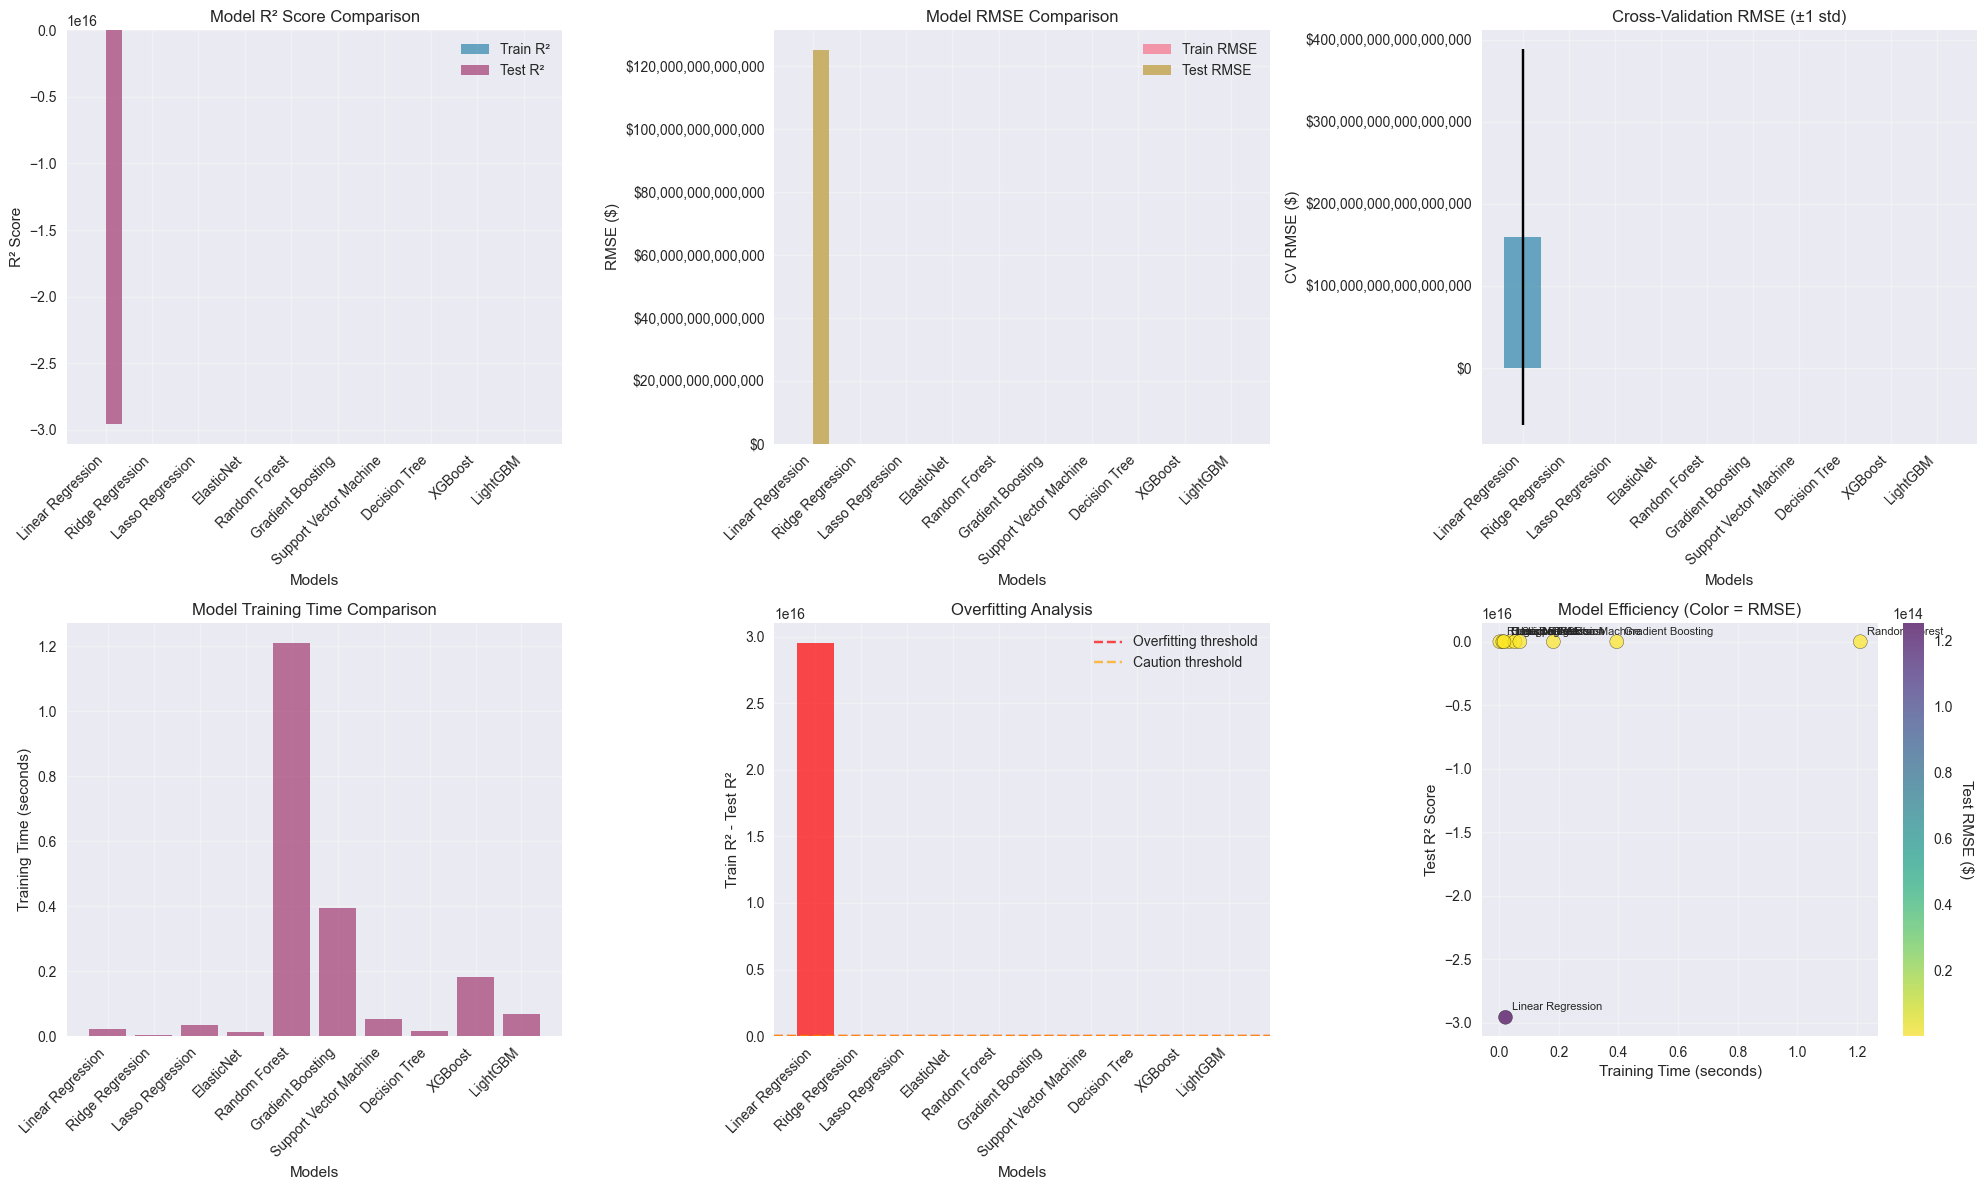


📈 Detailed Performance Summary:
                             test_r2     test_rmse      test_mae  \
XGBoost                 7.750000e-01  3.453409e+05  1.028798e+05   
LightGBM                7.279000e-01  3.798003e+05  1.394954e+05   
Gradient Boosting       5.934000e-01  4.642623e+05  1.489313e+05   
Random Forest           5.008000e-01  5.144079e+05  1.349782e+05   
ElasticNet              4.805000e-01  5.247262e+05  2.370701e+05   
Decision Tree           2.905000e-01  6.132332e+05  1.495419e+05   
Support Vector Machine -5.050000e-02  7.462146e+05  3.610824e+05   
Ridge Regression       -8.132000e-01  9.803490e+05  3.149049e+05   
Lasso Regression       -9.151000e-01  1.007518e+06  3.226048e+05   
Linear Regression      -2.956706e+16  1.251874e+14  7.965485e+12   

                           test_mape  cv_rmse_mean  training_time  
XGBoost                 1.285250e+01  4.301845e+05         0.1815  
LightGBM                2.099960e+01  4.802165e+05         0.0690  
Gradient Boost

In [ ]:
# Visualization of model performance comparison
if 'model_results' in locals() and model_results:
    print("📊 Creating model performance visualizations...")
    
    # Create comprehensive comparison plots
    fig = plt.figure(figsize=(20, 12))
    
    # 1. R² Score comparison
    ax1 = plt.subplot(2, 3, 1)
    models_names = list(model_results.keys())
    train_r2 = [model_results[name]['train_r2'] for name in models_names]
    test_r2 = [model_results[name]['test_r2'] for name in models_names]
    
    x_pos = np.arange(len(models_names))
    width = 0.35
    
    ax1.bar(x_pos - width/2, train_r2, width, label='Train R²', color=COLORS['primary'], alpha=0.7)
    ax1.bar(x_pos + width/2, test_r2, width, label='Test R²', color=COLORS['secondary'], alpha=0.7)
    
    ax1.set_xlabel('Models')
    ax1.set_ylabel('R² Score')
    ax1.set_title('Model R² Score Comparison')
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(models_names, rotation=45, ha='right')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. RMSE comparison
    ax2 = plt.subplot(2, 3, 2)
    train_rmse = [model_results[name]['train_rmse'] for name in models_names]
    test_rmse = [model_results[name]['test_rmse'] for name in models_names]
    
    ax2.bar(x_pos - width/2, train_rmse, width, label='Train RMSE', alpha=0.7) #, color=COLORS['accent1']
    ax2.bar(x_pos + width/2, test_rmse, width, label='Test RMSE', alpha=0.7)
    
    ax2.set_xlabel('Models')
    ax2.set_ylabel('RMSE ($)')
    ax2.set_title('Model RMSE Comparison')
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(models_names, rotation=45, ha='right')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
    
    # 3. Cross-validation RMSE with error bars
    ax3 = plt.subplot(2, 3, 3)
    cv_means = [model_results[name]['cv_rmse_mean'] for name in models_names]
    cv_stds = [model_results[name]['cv_rmse_std'] for name in models_names]
    
    bars = ax3.bar(x_pos, cv_means, yerr=cv_stds, capsize=5, 
                   color=COLORS['primary'], alpha=0.7, error_kw={'color': 'black'})
    
    ax3.set_xlabel('Models')
    ax3.set_ylabel('CV RMSE ($)')
    ax3.set_title('Cross-Validation RMSE (±1 std)')
    ax3.set_xticks(x_pos)
    ax3.set_xticklabels(models_names, rotation=45, ha='right')
    ax3.grid(True, alpha=0.3)
    ax3.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
    
    # 4. Training time comparison
    ax4 = plt.subplot(2, 3, 4)
    training_times = [model_results[name]['training_time'] for name in models_names]
    
    bars = ax4.bar(x_pos, training_times, color=COLORS['secondary'], alpha=0.7)
    ax4.set_xlabel('Models')
    ax4.set_ylabel('Training Time (seconds)')
    ax4.set_title('Model Training Time Comparison')
    ax4.set_xticks(x_pos)
    ax4.set_xticklabels(models_names, rotation=45, ha='right')
    ax4.grid(True, alpha=0.3)
    
    # 5. Overfitting analysis (Train R² - Test R²)
    ax5 = plt.subplot(2, 3, 5)
    overfitting = [model_results[name]['train_r2'] - model_results[name]['test_r2'] for name in models_names]
    
    colors = ['red' if x > 0.1 else 'green' if x < 0.05 else 'orange' for x in overfitting]
    bars = ax5.bar(x_pos, overfitting, color=colors, alpha=0.7)
    
    ax5.axhline(y=0.1, color='red', linestyle='--', alpha=0.7, label='Overfitting threshold')
    ax5.axhline(y=0.05, color='orange', linestyle='--', alpha=0.7, label='Caution threshold')
    ax5.set_xlabel('Models')
    ax5.set_ylabel('Train R² - Test R²')
    ax5.set_title('Overfitting Analysis')
    ax5.set_xticks(x_pos)
    ax5.set_xticklabels(models_names, rotation=45, ha='right')
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    
    # 6. Model efficiency scatter plot (R² vs Training Time)
    ax6 = plt.subplot(2, 3, 6)
    
    scatter = ax6.scatter(training_times, test_r2, s=100, c=test_rmse, 
                         cmap='viridis_r', alpha=0.7, edgecolors='black')
    
    # Add model names as annotations
    for i, name in enumerate(models_names):
        ax6.annotate(name, (training_times[i], test_r2[i]), 
                    xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    ax6.set_xlabel('Training Time (seconds)')
    ax6.set_ylabel('Test R² Score')
    ax6.set_title('Model Efficiency (Color = RMSE)')
    ax6.grid(True, alpha=0.3)
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax6)
    cbar.set_label('Test RMSE ($)', rotation=270, labelpad=15)
    
    plt.tight_layout()
    plt.show()
    
    # Performance summary table
    print(f"\n📈 Detailed Performance Summary:")
    print(f"{'='*100}")
    
    summary_df = pd.DataFrame.from_dict(model_results, orient='index')
    summary_df = summary_df.sort_values('test_r2', ascending=False)
    
    print(summary_df[['test_r2', 'test_rmse', 'test_mae', 'test_mape', 
                     'cv_rmse_mean', 'training_time']].round(4))

else:
    print("❌ No model results available for visualization")

In [51]:
# Hyperparameter tuning for best models
if 'results_df' in locals() and len(results_df) > 0:
    print("🔧 Starting hyperparameter tuning for top models...")
    
    # Select top 3 models for tuning
    top_models = results_df.head(3).index.tolist()
    print(f"   🎯 Selected models for tuning: {', '.join(top_models)}")
    
    # Define parameter grids for each model
    param_grids = {
        'Random Forest': {
            'n_estimators': [50, 100, 200],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        },
        'Gradient Boosting': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7],
            'subsample': [0.8, 0.9, 1.0]
        },
        'XGBoost': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7],
            'subsample': [0.8, 0.9, 1.0],
            'colsample_bytree': [0.8, 0.9, 1.0]
        },
        'LightGBM': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7],
            'subsample': [0.8, 0.9, 1.0],
            'colsample_bytree': [0.8, 0.9, 1.0]
        },
        'Ridge Regression': {
            'alpha': [0.1, 1.0, 10.0, 100.0, 1000.0]
        },
        'Lasso Regression': {
            'alpha': [0.1, 1.0, 10.0, 100.0, 1000.0]
        },
        'ElasticNet': {
            'alpha': [0.1, 1.0, 10.0],
            'l1_ratio': [0.1, 0.5, 0.7, 0.9]
        },
        'Support Vector Machine': {
            'C': [0.1, 1, 10, 100],
            'gamma': ['scale', 'auto', 0.001, 0.01],
            'epsilon': [0.01, 0.1, 0.2]
        }
    }
    
    tuned_models = {}
    tuning_results = {}
    
    for model_name in top_models:
        if model_name not in param_grids:
            print(f"   ⚠️ No parameter grid defined for {model_name}, skipping...")
            continue
            
        print(f"\n{'='*60}")
        print(f"🔧 Tuning {model_name}")
        print(f"{'='*60}")
        
        try:
            # Get the base model
            base_model = models_dict[model_name]
            
            # Choose appropriate data
            if model_name in tree_based_models:
                X_train_tune = X_train
                X_test_tune = X_test
                print(f"   📊 Using original features")
            else:
                X_train_tune = X_train_scaled
                X_test_tune = X_test_scaled
                print(f"   📊 Using scaled features")
            
            # Setup GridSearchCV
            param_grid = param_grids[model_name]
            print(f"   🔍 Parameter combinations to test: {np.prod([len(v) for v in param_grid.values()])}")
            
            # Use fewer CV folds for faster tuning
            cv_tune = KFold(n_splits=3, shuffle=True, random_state=42)
            
            grid_search = GridSearchCV(
                estimator=base_model,
                param_grid=param_grid,
                scoring='neg_root_mean_squared_error',
                cv=cv_tune,
                n_jobs=-1,
                verbose=0
            )
            
            # Fit the grid search
            start_time = time.time()
            grid_search.fit(X_train_tune, y_train)
            tuning_time = time.time() - start_time
            
            print(f"   ⏱️ Tuning time: {tuning_time:.1f} seconds")
            print(f"   🎯 Best CV RMSE: ${-grid_search.best_score_:,.0f}")
            print(f"   🔧 Best parameters:")
            
            for param, value in grid_search.best_params_.items():
                print(f"      {param}: {value}")
            
            # Evaluate tuned model
            best_model = grid_search.best_estimator_
            metrics, y_train_pred, y_test_pred = evaluate_model(
                best_model, X_train_tune, X_test_tune, y_train, y_test, 
                f"{model_name} (Tuned)"
            )
            
            # Store results
            tuned_models[model_name] = {
                'model': best_model,
                'grid_search': grid_search,
                'predictions': {'train': y_train_pred, 'test': y_test_pred},
                'scaled_data': model_name not in tree_based_models
            }
            
            tuning_results[model_name] = {
                **metrics,
                'tuning_time': tuning_time,
                'best_params': grid_search.best_params_,
                'cv_best_score': -grid_search.best_score_
            }
            
            print(f"   ✅ {model_name} tuning completed successfully")
            
        except Exception as e:
            print(f"   ❌ Error tuning {model_name}: {str(e)}")
            continue
    
    # Compare original vs tuned models
    if tuning_results:
        print(f"\n{'='*80}")
        print(f"📊 HYPERPARAMETER TUNING RESULTS")
        print(f"{'='*80}")
        
        print(f"\n🔄 Before vs After Tuning Comparison:")
        print(f"{'Model':<20} {'Original R²':<12} {'Tuned R²':<12} {'Improvement':<12} {'Time(s)':<10}")
        print(f"{'-'*75}")
        
        for model_name in tuning_results.keys():
            original_r2 = model_results[model_name]['test_r2']
            tuned_r2 = tuning_results[model_name]['test_r2']
            improvement = tuned_r2 - original_r2
            tuning_time = tuning_results[model_name]['tuning_time']
            
            print(f"{model_name:<20} {original_r2:<12.4f} {tuned_r2:<12.4f} "
                  f"{improvement:<12.4f} {tuning_time:<10.1f}")
        
        # Find best tuned model
        best_tuned_name = max(tuning_results.keys(), 
                             key=lambda x: tuning_results[x]['test_r2'])
        best_tuned_metrics = tuning_results[best_tuned_name]
        
        print(f"\n🥇 Best Tuned Model: {best_tuned_name}")
        print(f"   Test R²:    {best_tuned_metrics['test_r2']:.4f}")
        print(f"   Test RMSE:  ${best_tuned_metrics['test_rmse']:,.0f}")
        print(f"   Test MAE:   ${best_tuned_metrics['test_mae']:,.0f}")
        print(f"   Test MAPE:  {best_tuned_metrics['test_mape']:.2f}%")
        
        # Store best tuned model
        final_best_model = tuned_models[best_tuned_name]['model']
        final_best_name = f"{best_tuned_name} (Tuned)"
        
    else:
        print("❌ No models were successfully tuned")
        final_best_model = best_model
        final_best_name = best_model_name

else:
    print("❌ Cannot perform hyperparameter tuning - no baseline results available")

🔧 Starting hyperparameter tuning for top models...
   🎯 Selected models for tuning: XGBoost, LightGBM, Gradient Boosting

🔧 Tuning XGBoost
   📊 Using original features
   🔍 Parameter combinations to test: 243
   ⏱️ Tuning time: 36.1 seconds
   🎯 Best CV RMSE: $364,667
   🔧 Best parameters:
      colsample_bytree: 0.8
      learning_rate: 0.1
      max_depth: 5
      n_estimators: 200
      subsample: 0.8

🎯 Evaluating XGBoost (Tuned)...
   📊 Training Metrics:
      R² Score: 0.9991
      RMSE:     $25,316
      MAE:      $19,346
      MAPE:     5.01%
   📊 Test Metrics:
      R² Score: 0.8606
      RMSE:     $271,789
      MAE:      $97,843
      MAPE:     16.88%
   ⚠️ Potential overfitting detected (R² difference: 0.139)
   ✅ XGBoost tuning completed successfully

🔧 Tuning LightGBM
   📊 Using original features
   🔍 Parameter combinations to test: 243
   ⏱️ Tuning time: 477.9 seconds
   🎯 Best CV RMSE: $505,805
   🔧 Best parameters:
      colsample_bytree: 0.8
      learning_rate: 0.2
 

🎯 Detailed Analysis of Best Model: XGBoost (Tuned)
   📊 Using original features for analysis

🔍 Feature Importance Analysis:
   📈 Top 15 Most Important Features:
    1. gov_ben_arous            : 0.3889
    2. market_segment_Luxury    : 0.2125
    3. price_per_sqm            : 0.0474
    4. is_apartment             : 0.0411
    5. market_segment_Upper-Mid : 0.0371
    6. living_to_land_ratio     : 0.0359
    7. living_area              : 0.0274
    8. bathroom_count           : 0.0255
    9. market_segment_Entry-Level: 0.0227
   10. market_segment_Mid-Market: 0.0195
   11. punctuation_density      : 0.0157
   12. total_area               : 0.0136
   13. property_tier_Basic      : 0.0128
   14. land_area                : 0.0128
   15. avg_room_size            : 0.0091


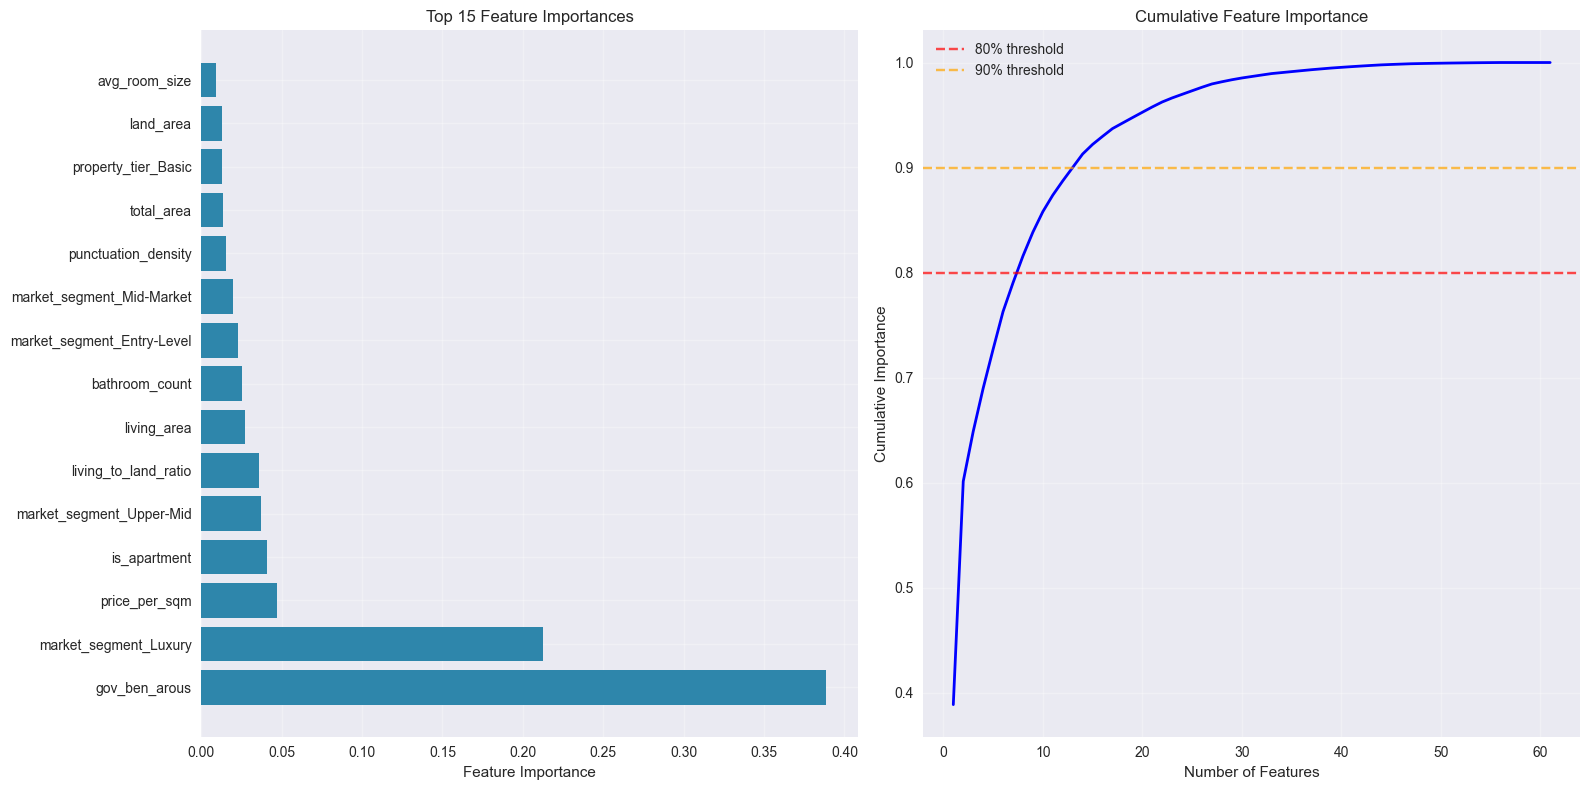

   📊 Features needed for 80% importance: 8
   📊 Features needed for 90% importance: 13

📊 Prediction Analysis:


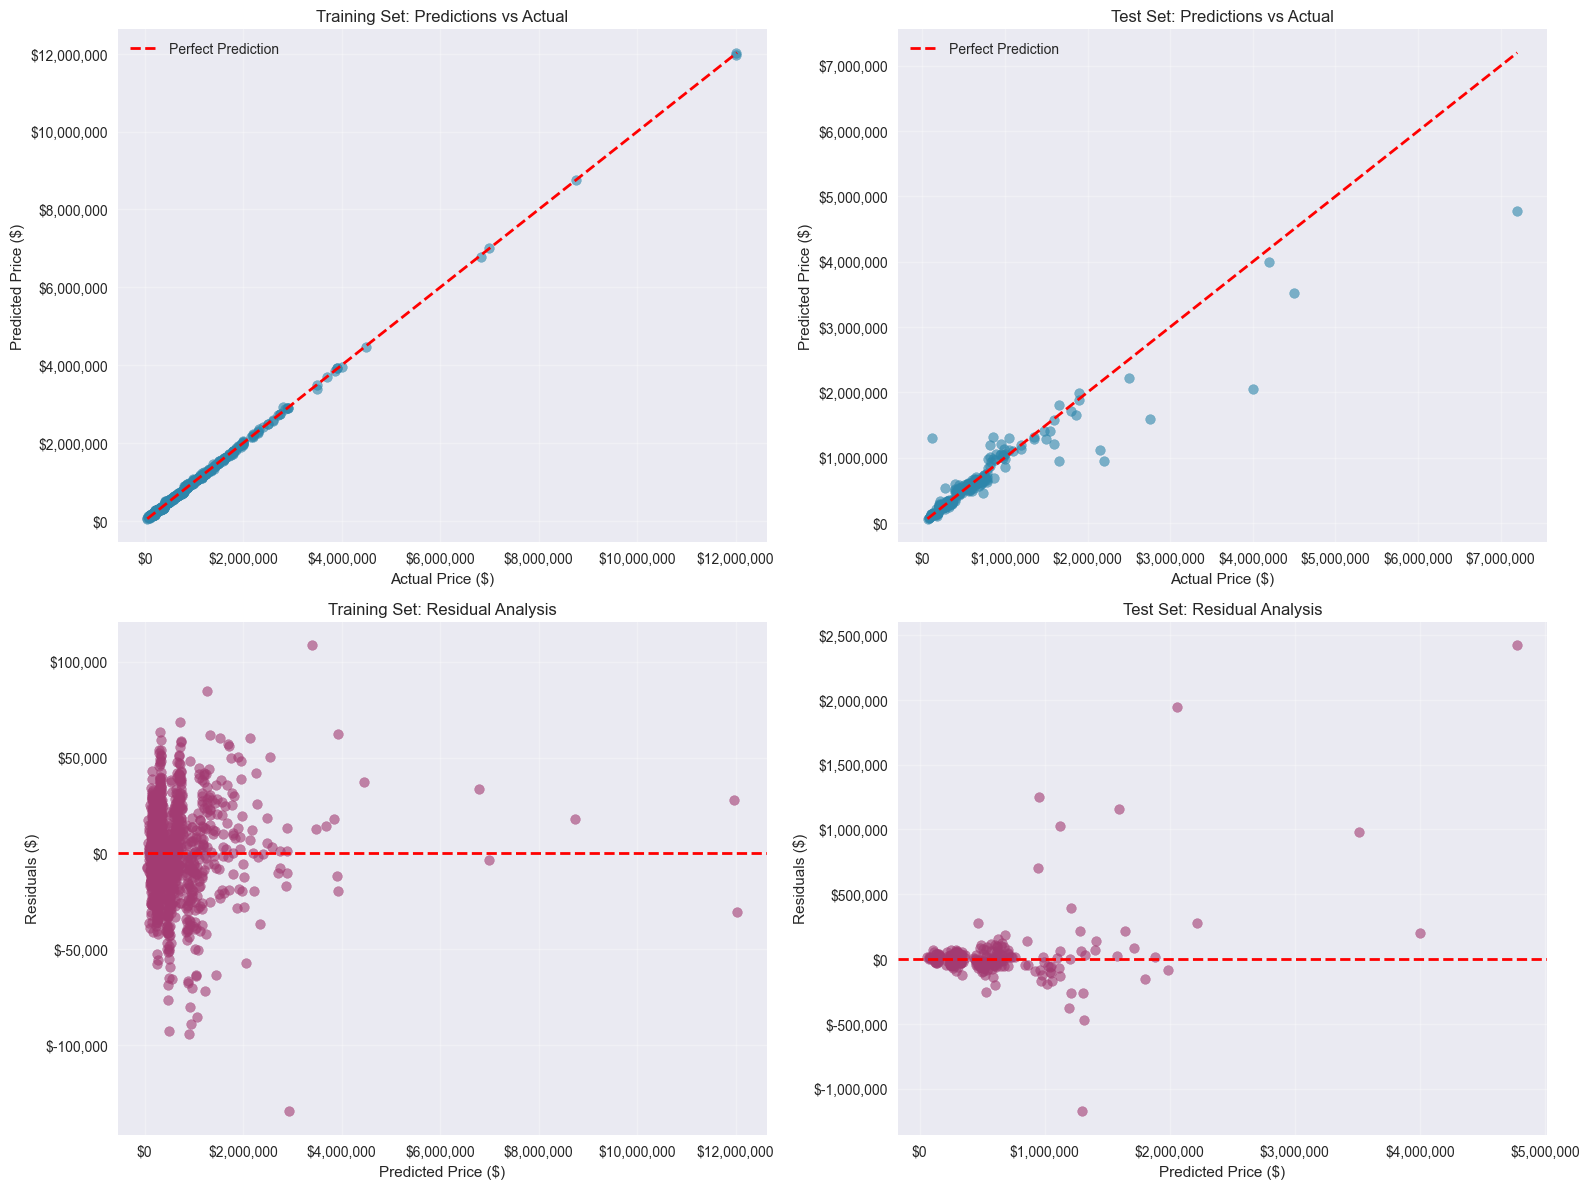


📈 Error Distribution Analysis:
   Training Residuals:
      Mean:   $-78
      Std:    $25,328
      Min:    $-134,520
      Max:    $108,641
   Test Residuals:
      Mean:   $28,508
      Std:    $270,839
      Min:    $-1,174,697
      Max:    $2,421,742


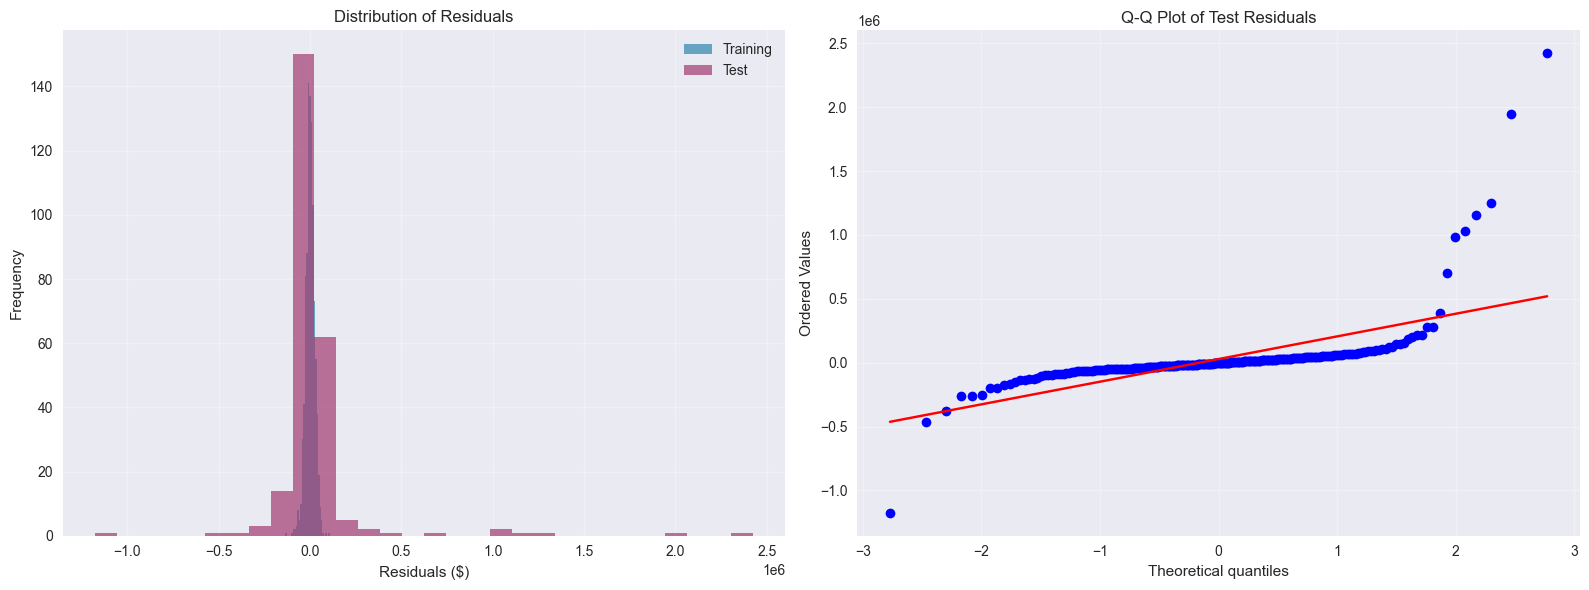


💰 Prediction Accuracy by Price Range:
   Medium ($50K-100K)  :   6 samples, MAE: $  7,892, MAPE:   9.1%, R²: -0.573
   High ($100K-200K)   :  28 samples, MAE: $ 65,630, MAPE:  50.5%, R²: -61.280
   Very High ($200K+)  : 213 samples, MAE: $104,611, MAPE:  12.7%, R²: 0.862


In [52]:
# Detailed analysis of best model and feature importance
if 'final_best_model' in locals() and final_best_model is not None:
    print(f"🎯 Detailed Analysis of Best Model: {final_best_name}")
    print(f"{'='*80}")
    
    # Choose appropriate data for the best model
    if final_best_name.split(' (')[0] in tree_based_models:
        X_train_final = X_train
        X_test_final = X_test
        feature_names = X_train.columns.tolist()
        print(f"   📊 Using original features for analysis")
    else:
        X_train_final = X_train_scaled
        X_test_final = X_test_scaled
        feature_names = X_train.columns.tolist()  # Names remain the same
        print(f"   📊 Using scaled features for analysis")
    
    # Get final predictions
    y_train_final_pred = final_best_model.predict(X_train_final)
    y_test_final_pred = final_best_model.predict(X_test_final)
    
    # Feature importance analysis
    print(f"\n🔍 Feature Importance Analysis:")
    
    if hasattr(final_best_model, 'feature_importances_'):
        # Tree-based models
        importances = final_best_model.feature_importances_
        feature_importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': importances
        }).sort_values('importance', ascending=False)
        
        print(f"   📈 Top 15 Most Important Features:")
        for i, (idx, row) in enumerate(feature_importance_df.head(15).iterrows(), 1):
            print(f"   {i:2d}. {row['feature']:<25s}: {row['importance']:.4f}")
        
        # Plot feature importance
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
        
        # Top 15 features
        top_features = feature_importance_df.head(15)
        ax1.barh(range(len(top_features)), top_features['importance'].values, 
                color=COLORS['primary'])
        ax1.set_yticks(range(len(top_features)))
        ax1.set_yticklabels(top_features['feature'].values)
        ax1.set_xlabel('Feature Importance')
        ax1.set_title('Top 15 Feature Importances')
        ax1.grid(True, alpha=0.3)
        
        # Cumulative importance
        cumsum = feature_importance_df['importance'].cumsum()
        ax2.plot(range(1, len(cumsum) + 1), cumsum, 'b-', linewidth=2)
        ax2.axhline(y=0.8, color='r', linestyle='--', alpha=0.7, label='80% threshold')
        ax2.axhline(y=0.9, color='orange', linestyle='--', alpha=0.7, label='90% threshold')
        ax2.set_xlabel('Number of Features')
        ax2.set_ylabel('Cumulative Importance')
        ax2.set_title('Cumulative Feature Importance')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Features for 80% and 90% importance
        features_80 = (cumsum <= 0.8).sum() + 1
        features_90 = (cumsum <= 0.9).sum() + 1
        print(f"   📊 Features needed for 80% importance: {features_80}")
        print(f"   📊 Features needed for 90% importance: {features_90}")
        
    elif hasattr(final_best_model, 'coef_'):
        # Linear models
        coefficients = np.abs(final_best_model.coef_)
        feature_importance_df = pd.DataFrame({
            'feature': feature_names,
            'abs_coefficient': coefficients
        }).sort_values('abs_coefficient', ascending=False)
        
        print(f"   📈 Top 15 Features by Absolute Coefficient:")
        for i, (idx, row) in enumerate(feature_importance_df.head(15).iterrows(), 1):
            print(f"   {i:2d}. {row['feature']:<25s}: {row['abs_coefficient']:.4f}")
    
    # Prediction analysis
    print(f"\n📊 Prediction Analysis:")
    
    # Create prediction plots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Training predictions vs actual
    plot_predictions(y_train, y_train_final_pred, "Training Set: Predictions vs Actual", ax1)
    
    # 2. Test predictions vs actual
    plot_predictions(y_test, y_test_final_pred, "Test Set: Predictions vs Actual", ax2)
    
    # 3. Training residuals
    plot_residuals(y_train, y_train_final_pred, "Training Set: Residual Analysis", ax3)
    
    # 4. Test residuals
    plot_residuals(y_test, y_test_final_pred, "Test Set: Residual Analysis", ax4)
    
    plt.tight_layout()
    plt.show()
    
    # Prediction error analysis
    test_residuals = y_test - y_test_final_pred
    train_residuals = y_train - y_train_final_pred
    
    print(f"\n📈 Error Distribution Analysis:")
    print(f"   Training Residuals:")
    print(f"      Mean:   ${train_residuals.mean():,.0f}")
    print(f"      Std:    ${train_residuals.std():,.0f}")
    print(f"      Min:    ${train_residuals.min():,.0f}")
    print(f"      Max:    ${train_residuals.max():,.0f}")
    
    print(f"   Test Residuals:")
    print(f"      Mean:   ${test_residuals.mean():,.0f}")
    print(f"      Std:    ${test_residuals.std():,.0f}")
    print(f"      Min:    ${test_residuals.min():,.0f}")
    print(f"      Max:    ${test_residuals.max():,.0f}")
    
    # Residual distribution plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Histogram of residuals
    ax1.hist(train_residuals, bins=30, alpha=0.7, color=COLORS['primary'], label='Training')
    ax1.hist(test_residuals, bins=30, alpha=0.7, color=COLORS['secondary'], label='Test')
    ax1.set_xlabel('Residuals ($)')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Distribution of Residuals')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Q-Q plot for normality check
    from scipy import stats
    stats.probplot(test_residuals, dist="norm", plot=ax2)
    ax2.set_title('Q-Q Plot of Test Residuals')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Price range analysis
    print(f"\n💰 Prediction Accuracy by Price Range:")
    
    # Define price ranges
    price_ranges = [
        (0, 50000, "Low ($0-50K)"),
        (50000, 100000, "Medium ($50K-100K)"),
        (100000, 200000, "High ($100K-200K)"),
        (200000, float('inf'), "Very High ($200K+)")
    ]
    
    for min_price, max_price, label in price_ranges:
        mask = (y_test >= min_price) & (y_test < max_price)
        if mask.sum() > 0:
            range_actual = y_test[mask]
            range_pred = y_test_final_pred[mask]
            range_mae = mean_absolute_error(range_actual, range_pred)
            range_mape = np.mean(np.abs((range_actual - range_pred) / range_actual)) * 100
            range_r2 = r2_score(range_actual, range_pred)
            
            print(f"   {label:20s}: {mask.sum():3d} samples, "
                  f"MAE: ${range_mae:7,.0f}, MAPE: {range_mape:5.1f}%, R²: {range_r2:.3f}")

else:
    print("❌ Cannot perform detailed analysis - no best model available")

In [53]:
# Model saving and final summary
import pickle
import joblib
from datetime import datetime

if 'final_best_model' in locals() and final_best_model is not None:
    print(f"💾 Saving Best Model and Results")
    print(f"{'='*60}")
    
    # Create models directory if it doesn't exist
    models_dir = os.path.join(os.getcwd(), '..', 'models')
    os.makedirs(models_dir, exist_ok=True)
    
    # Generate timestamp for unique filenames
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Save the best model
    model_filename = f"best_model_{timestamp}.pkl"
    model_path = os.path.join(models_dir, model_filename)
    
    try:
        joblib.dump(final_best_model, model_path)
        print(f"   ✅ Model saved: {model_filename}")
    except Exception as e:
        print(f"   ❌ Error saving model: {str(e)}")
    
    # Save the scaler if used
    if final_best_name.split(' (')[0] not in tree_based_models:
        scaler_filename = f"scaler_{timestamp}.pkl"
        scaler_path = os.path.join(models_dir, scaler_filename)
        
        try:
            joblib.dump(scaler, scaler_path)
            print(f"   ✅ Scaler saved: {scaler_filename}")
        except Exception as e:
            print(f"   ❌ Error saving scaler: {str(e)}")
    
    # Save feature names and model metadata
    metadata = {
        'model_name': final_best_name,
        'feature_names': feature_names,
        'model_type': type(final_best_model).__name__,
        'training_date': datetime.now().isoformat(),
        'feature_count': len(feature_names),
        'training_samples': len(X_train),
        'test_samples': len(X_test),
        'uses_scaling': final_best_name.split(' (')[0] not in tree_based_models,
        'performance_metrics': {
            'test_r2': float(r2_score(y_test, y_test_final_pred)),
            'test_rmse': float(np.sqrt(mean_squared_error(y_test, y_test_final_pred))),
            'test_mae': float(mean_absolute_error(y_test, y_test_final_pred)),
            'test_mape': float(np.mean(np.abs((y_test - y_test_final_pred) / y_test)) * 100)
        }
    }
    
    # Add hyperparameters if available
    if hasattr(final_best_model, 'get_params'):
        metadata['hyperparameters'] = final_best_model.get_params()
    
    metadata_filename = f"model_metadata_{timestamp}.pkl"
    metadata_path = os.path.join(models_dir, metadata_filename)
    
    try:
        with open(metadata_path, 'wb') as f:
            pickle.dump(metadata, f)
        print(f"   ✅ Metadata saved: {metadata_filename}")
    except Exception as e:
        print(f"   ❌ Error saving metadata: {str(e)}")
    
    # Create a simple prediction function
    prediction_code = f'''
import joblib
import pandas as pd
import numpy as np

def load_model():
    """Load the trained model and scaler."""
    model = joblib.load("{model_filename}")
    {"scaler = joblib.load('" + scaler_filename + "')" if final_best_name.split(' (')[0] not in tree_based_models else "scaler = None"}
    return model, scaler

def predict_price(features_dict):
    """
    Predict house price from feature dictionary.
    
    Args:
        features_dict: Dictionary with feature names as keys and values as values
        
    Returns:
        Predicted price
    """
    model, scaler = load_model()
    
    # Convert to DataFrame
    df = pd.DataFrame([features_dict])
    
    # Ensure all features are present
    expected_features = {repr(feature_names)}
    for feature in expected_features:
        if feature not in df.columns:
            df[feature] = 0  # Default value for missing features
    
    # Reorder columns to match training
    df = df[expected_features]
    
    # Scale if necessary
    {"X = scaler.transform(df)" if final_best_name.split(' (')[0] not in tree_based_models else "X = df.values"}
    
    # Predict
    prediction = model.predict(X)[0]
    
    return prediction

# Example usage:
# price = predict_price({{"area": 100, "rooms": 3, "bathrooms": 2, ...}})
'''
    
    prediction_filename = f"predict_function_{timestamp}.py"
    prediction_path = os.path.join(models_dir, prediction_filename)
    
    try:
        with open(prediction_path, 'w') as f:
            f.write(prediction_code)
        print(f"   ✅ Prediction function saved: {prediction_filename}")
    except Exception as e:
        print(f"   ❌ Error saving prediction function: {str(e)}")
    
    print(f"\n📋 FINAL MODEL SUMMARY")
    print(f"{'='*60}")
    print(f"🏆 Best Model: {final_best_name}")
    print(f"📊 Model Type: {type(final_best_model).__name__}")
    print(f"🔢 Features Used: {len(feature_names)}")
    print(f"📈 Training Samples: {len(X_train):,}")
    print(f"📉 Test Samples: {len(X_test):,}")
    
    # Final performance metrics
    final_r2 = r2_score(y_test, y_test_final_pred)
    final_rmse = np.sqrt(mean_squared_error(y_test, y_test_final_pred))
    final_mae = mean_absolute_error(y_test, y_test_final_pred)
    final_mape = np.mean(np.abs((y_test - y_test_final_pred) / y_test)) * 100
    
    print(f"\n🎯 Final Performance:")
    print(f"   R² Score:     {final_r2:.4f}")
    print(f"   RMSE:         ${final_rmse:,.0f}")
    print(f"   MAE:          ${final_mae:,.0f}")
    print(f"   MAPE:         {final_mape:.2f}%")
    
    # Model interpretation
    print(f"\n🧠 Model Interpretation:")
    if final_mape < 10:
        print(f"   ✅ Excellent model accuracy (MAPE < 10%)")
    elif final_mape < 20:
        print(f"   👍 Good model accuracy (MAPE < 20%)")
    elif final_mape < 30:
        print(f"   ⚠️ Moderate model accuracy (MAPE < 30%)")
    else:
        print(f"   ❌ Poor model accuracy (MAPE > 30%)")
    
    if final_r2 > 0.8:
        print(f"   ✅ Strong predictive power (R² > 0.8)")
    elif final_r2 > 0.6:
        print(f"   👍 Good predictive power (R² > 0.6)")
    elif final_r2 > 0.4:
        print(f"   ⚠️ Moderate predictive power (R² > 0.4)")
    else:
        print(f"   ❌ Weak predictive power (R² < 0.4)")
    
    print(f"\n📁 Saved Files:")
    print(f"   Model:      {model_filename}")
    if final_best_name.split(' (')[0] not in tree_based_models:
        print(f"   Scaler:     {scaler_filename}")
    print(f"   Metadata:   {metadata_filename}")
    print(f"   Predictor:  {prediction_filename}")
    
    print(f"\n🎉 Model training and evaluation completed successfully!")
    print(f"   📍 All files saved in: {models_dir}")
    print(f"   🚀 Ready for deployment!")

else:
    print("❌ Cannot save model - no trained model available")

print(f"\n{'='*80}")
print(f"🎯 MACHINE LEARNING PIPELINE COMPLETED")
print(f"{'='*80}")

💾 Saving Best Model and Results
   ✅ Model saved: best_model_20250906_043926.pkl
   ✅ Metadata saved: model_metadata_20250906_043926.pkl
   ✅ Prediction function saved: predict_function_20250906_043926.py

📋 FINAL MODEL SUMMARY
🏆 Best Model: XGBoost (Tuned)
📊 Model Type: XGBRegressor
🔢 Features Used: 61
📈 Training Samples: 984
📉 Test Samples: 247

🎯 Final Performance:
   R² Score:     0.8606
   RMSE:         $271,789
   MAE:          $97,843
   MAPE:         16.88%

🧠 Model Interpretation:
   👍 Good model accuracy (MAPE < 20%)
   ✅ Strong predictive power (R² > 0.8)

📁 Saved Files:
   Model:      best_model_20250906_043926.pkl
   Metadata:   model_metadata_20250906_043926.pkl
   Predictor:  predict_function_20250906_043926.py

🎉 Model training and evaluation completed successfully!
   📍 All files saved in: c:\Users\Razer\Documents\2025_work\House_price_prediction\notebooks\..\models
   🚀 Ready for deployment!

🎯 MACHINE LEARNING PIPELINE COMPLETED
